# Postprocessing for FEniCSx example

[![Jupyter4NFDI](https://nfdi-jupyter.de/images/jupyter4nfdi_badge.svg)](https://hub.nfdi-jupyter.de/v2/gh/BAMresearch/NFDI4IngModelValidationPlatform/HEAD?labpath=docs%2Fbenchmarks%2Flinear%20elasticity%2Fplate_with_hole.ipynb)

In [1]:
import json

import pyvista
from pathlib import Path
import xml.etree.ElementTree as ET
import meshio
import numpy as np
import pint

ureg = pint.UnitRegistry()

class PlateWithHoleSolution:
    def __init__(self, E, nu, radius, L, load):
        self.radius = radius
        self.L = L
        self.load = load
        self.E = E
        self.nu = nu

    def polar(self, x):
        r = np.hypot(x[0], x[1])
        theta = np.atan2(x[1], x[0])
        return r, theta

    def displacement(self, x):
        r, theta = self.polar(x)
        a = self.radius

        T = self.load
        Ta_8mu = T * a / (4 * self.E / (1.0 + 1.0 * self.nu))
        k = (3.0 - self.nu) / (1.0 + self.nu)

        ct = np.cos(theta)
        c3t = np.cos(3 * theta)
        st = np.sin(theta)
        s3t = np.sin(3 * theta)

        fac = 2 * np.pow(a / r, 3)

        ux = Ta_8mu * (
            r / a * (k + 1.0) * ct + 2.0 * a / r * ((1.0 + k) * ct + c3t) - fac * c3t
        )

        uy = Ta_8mu * (
            (r / a) * (k - 3.0) * st + 2.0 * a / r * ((1.0 - k) * st + s3t) - fac * s3t
        )

        return ux, uy, np.zeros_like(ux)

    def stress(self, x):
        r, theta = self.polar(x)
        T = self.load
        a = self.radius
        cos2t = np.cos(2 * theta)
        cos4t = np.cos(4 * theta)
        sin2t = np.sin(2 * theta)
        sin4t = np.sin(4 * theta)

        fac1 = (a * a) / (r * r)
        fac2 = 1.5 * fac1 * fac1

        sxx = T - T * fac1 * (1.5 * cos2t + cos4t) + T * fac2 * cos4t
        syy = -T * fac1 * (0.5 * cos2t - cos4t) - T * fac2 * cos4t
        sxy = -T * fac1 * (0.5 * sin2t + sin4t) + T * fac2 * sin4t

        return sxx, sxy, sxy, syy
    
    def mises_stress(self, x):
        sxx, sxy, _, syy = self.stress(x)
        
        return np.sqrt(
            0.5 * (
                (sxx - syy) ** 2 + sxx ** 2 + syy ** 2 + 6.0 * sxy ** 2
            )
        )

class Benchmark:
    def __init__(self, summary_file):
        root_path = Path(summary_file).parent
        with open(summary_file, "r") as f:
            self.summary = json.load(f)
        self.name = self.summary["name"]
        with open(root_path / self.summary["parameters"], "r") as f:
            self.parameters = json.load(f)
        with open(root_path / self.summary["input"], "r") as f:
            self.input = json.load(f)
        self.output = root_path / self.summary["output"]

    def read_output(self):
        if self.output.suffix == ".vtu":
            return pyvista.read(self.output)
        elif self.output.suffix == ".vtk":
            tree = ET.parse(self.output)
            root = tree.getroot()
            pvtu_filenames = []
            for dataset in root.findall(".//DataSet"):
                pvtu_filenames.append(dataset.get("file"))
            return [pyvista.read(self.output.parent / pvtu_filename) for pvtu_filename in pvtu_filenames]
        elif self.output.suffix == ".pvtu":
            return pyvista.read(self.output)
    def get_vtu(self):
        if self.output.suffix == ".vtu":
            return self.output
        elif self.output.suffix == ".vtk":
            tree = ET.parse(self.output)
            root = tree.getroot()
            for dataset in root.findall(".//DataSet"):
                pvtu_filename = self.output.parent / dataset.get("file")
            #return meshio.read(self.output.parent / pvtu_filename)
        elif self.output.suffix == ".pvtu":
            pvtu_filename = self.output
        
        # Load and parse the XML file
        tree = ET.parse(pvtu_filename)
        root = tree.getroot()

        # Find the Piece element and get the Source attribute
        piece_element = root.find('.//Piece')
        vtu_filename = piece_element.get('Source')

        return self.output.parent / vtu_filename
            
    def __repr__(self):
        return f"{self.name}: {self.parameters}"


directory = "../../../benchmarks/linear-elasticity-plate-with-hole/"
file_names = list(Path(directory).rglob("summary_*.json"))

# read the parameters
benchmarks = []
for file_name in file_names:
    benchmarks.append(Benchmark(file_name))

# Search for parameters where element-degree == 1 and the element-size differs
benchmarks = filter(
    lambda b: b.parameters["element-degree"] == 1
    and b.parameters["element-order"] == 1,
    benchmarks,
)
benchmarks_sorted = sorted(
    benchmarks, key=lambda b: b.parameters["element-size"]["value"], reverse=True
)
benchmarks_sorted
parameters = benchmarks_sorted[0].parameters
without_unit = {}

for key, value in parameters.items():
    try:
        without_unit[key] = ureg.Quantity(value["value"], value["unit"]).to_base_units().magnitude
    except TypeError:
        pass

analytical_solution = PlateWithHoleSolution(without_unit["young-modulus"], without_unit["poisson-ratio"], without_unit["radius"], without_unit["length"], without_unit["load"])

In [2]:
import meshhelper
from mpi4py import MPI
h = [b.parameters["element-size"]["value"] for b in benchmarks_sorted]
data = [b.read_output() for b in benchmarks_sorted]
data_u = [datapoint[i] for datapoint in data for i in range(0, len(datapoint)) if "u" in datapoint[i].array_names]
data_stress = [datapoint[i] for datapoint in data for i in range(0, len(datapoint)) if "stress" in datapoint[i].array_names]
data_dolfinx_u = [meshhelper.io.pyvista_mesh_to_dolfinx(MPI.COMM_SELF, datapoint, ["u"]) for datapoint in data_u]
data_dolfinx_stress = [meshhelper.io.pyvista_mesh_to_dolfinx(MPI.COMM_SELF, datapoint, ["stress"]) for datapoint in data_stress]

In [3]:
import dolfinx as df
import numpy as np
interpolated_data_inf = []
interpolated_data_l2 = []
for i in range(len(data_dolfinx_u)):
    fun_tmp = df.fem.Function(data_dolfinx_u[i][1]["u"].function_space)
    high_order_space = df.fem.functionspace(fun_tmp.function_space.mesh, ("CG", 3, (3,)))
    fun_tmp_high_order = df.fem.Function(high_order_space)
    fun_tmp_high_order.interpolate(lambda x: analytical_solution.displacement(x))
    fun_tmp_high_order.x.scatter_forward()
    fun_tmp.interpolate(lambda x: analytical_solution.displacement(x))
    fun_tmp.x.scatter_forward()
    interpolated_data_inf.append(fun_tmp)
    interpolated_data_l2.append(fun_tmp_high_order)

In [4]:
error_l2 = []
error_inf = []
import ufl

for i in range(len(data_dolfinx_u)):
    diff_l2 = data_dolfinx_u[i][1]["u"] - interpolated_data_l2[i]
    error_inf.append(np.linalg.norm( data_dolfinx_u[i][1]["u"].x.array - interpolated_data_inf[i].x.array, np.inf))
    error_l2_squared = df.fem.assemble_scalar(df.fem.form((ufl.inner(diff_l2,diff_l2)) * ufl.dx))
    error_l2.append(np.sqrt(error_l2_squared))

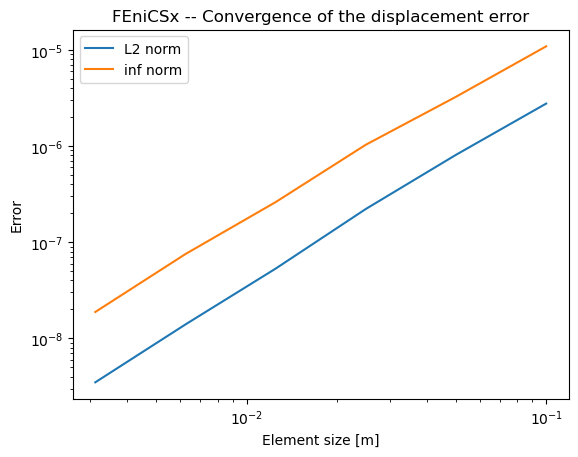

In [5]:
import matplotlib.pyplot as plt
plt.plot(h, error_l2, label="L2 norm")
plt.plot(h, error_inf, label="inf norm")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Element size [m]")
plt.ylabel("Error")
plt.title("FEniCSx -- Convergence of the displacement error")
plt.legend()

In [6]:
for datapoint in data_stress:
    trace = datapoint["stress"][:,0] + datapoint["stress"][:,3]
    stress_dev = np.array(datapoint["stress"])
    stress_dev[:,0] -= trace/3.0
    stress_dev[:,3] -= trace/3.0

    datapoint["mises_stress"] = np.sqrt((3.0/2.0) * (np.sum(stress_dev**2, axis=1) + (trace/3.0)**2.0))

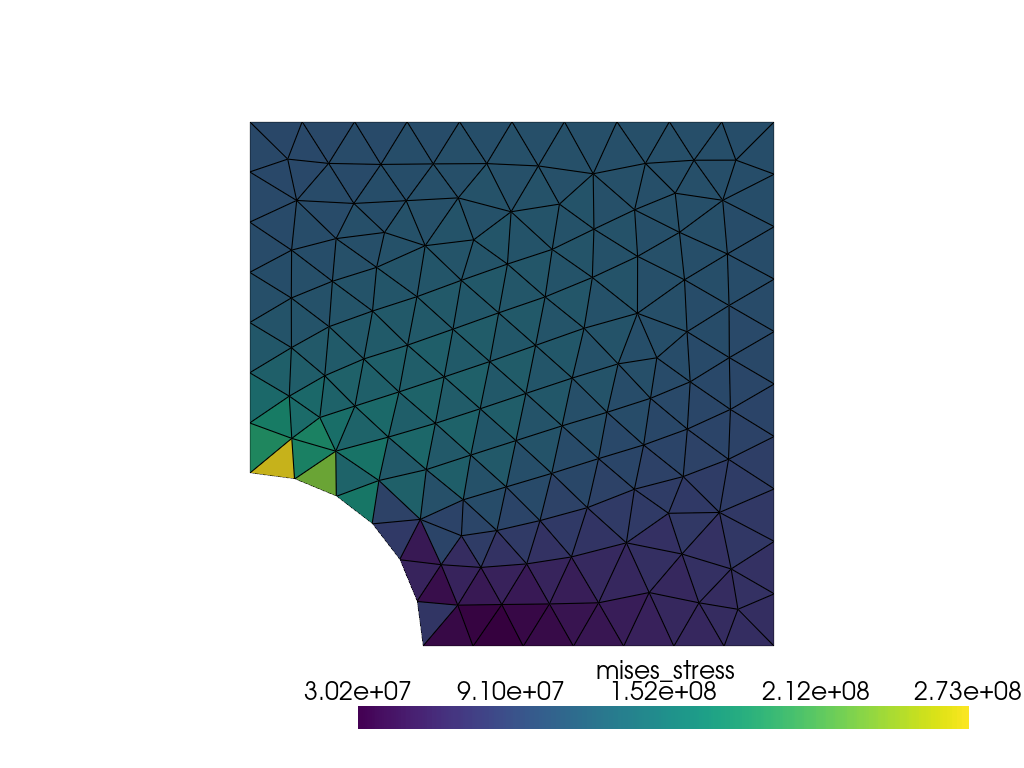

In [7]:
pyvista.global_theme.font.label_size = 25
pyvista.global_theme.font.title_size = 25
plotter = pyvista.Plotter()
plotter.add_mesh(data_stress[0], scalars="mises_stress", show_edges=True)
plotter.view_xy()

plotter.show()

In [8]:
interpolated_data_mises_inf = []
error_mises_inf = [] 
error_rel_mises_inf = []
norm_inf = []
for i in range(len(data_stress)):
    points = data_stress[i].cell_centers().points
    mises_analytical = analytical_solution.mises_stress((points[:,0], points[:,1]))
    error_mises_inf.append(np.linalg.norm(data_stress[i]["mises_stress"] - mises_analytical, np.inf))
    norm_inf.append(np.linalg.norm(mises_analytical, np.inf))
    error_rel_mises_inf.append(error_mises_inf[-1]/norm_inf[-1])
    mises_space = df.fem.functionspace(data_dolfinx_stress[i][1]["stress"].function_space.mesh, ("CG", 3))
    fun_tmp = df.fem.Function(data_dolfinx_stress[i][1]["stress"].function_space)


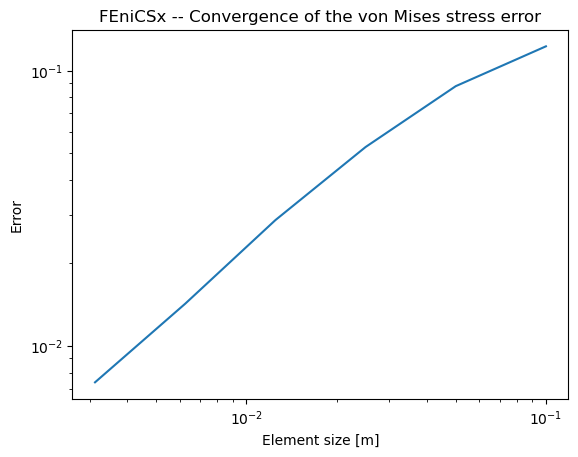

In [9]:
plt.plot(h, error_rel_mises_inf)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Element size [m]")
plt.ylabel("Error")
plt.title("FEniCSx -- Convergence of the von Mises stress error")
plt.show()